<a href="https://colab.research.google.com/github/deeplearningexplore/siamese/blob/main/question_pairs_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c quora-question-pairs

Saving kaggle.json to kaggle.json
 81% 4.00M/4.95M [00:00<00:00, 23.4MB/s]
100% 4.95M/4.95M [00:00<00:00, 24.3MB/s]
 97% 169M/173M [00:12<00:00, 28.0MB/s]
100% 173M/173M [00:12<00:00, 14.8MB/s]
 80% 17.0M/21.2M [00:02<00:00, 6.06MB/s]
100% 21.2M/21.2M [00:02<00:00, 7.59MB/s]
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import pandas as pd
import tensorflow.keras.backend as K
import tqdm


%matplotlib inline

In [3]:
zip = zipfile.ZipFile("test.csv.zip", "r")
zip.extractall("./data")


In [4]:
zip = zipfile.ZipFile("train.csv.zip", "r")
zip.extractall("./data")

zip.close()

In [5]:
!rm "train.csv.zip"
!rm "test.csv.zip"

In [6]:
train_data = pd.read_csv("./data/train.csv")
test_data = pd.read_csv("./data/test.csv")
print(train_data.head())
print(test_data.head())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


   id  qid1  ...                                          question2 is_duplicate
0   0     1  ...  What is the step by step guide to invest in sh...            0
1   1     3  ...  What would happen if the Indian government sto...            0
2   2     5  ...  How can Internet speed be increased by hacking...            0
3   3     7  ...  Find the remainder when [math]23^{24}[/math] i...            0
4   4     9  ...            Which fish would survive in salt water?            0

[5 rows x 6 columns]
  test_id  ...                                          question2
0       0  ...  Why did Microsoft choose core m3 and not core ...
1       1  ...        How much cost does hair transplant require?
2       2  ...                      What you send money to China?
3       3  ...                                  What foods fibre?
4       4  ...                     How their can I start reading?

[5 rows x 3 columns]


In [7]:
train_data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [8]:
train_data = train_data[train_data["is_duplicate"]==1]
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [9]:
train_d1 = train_data['question1'].values
train_d2 = train_data['question2'].values

In [10]:
train_d1.shape

(149263,)

In [11]:
train_d = np.concatenate([train_d1,train_d2])

In [12]:
train_d.shape

(298526,)

In [13]:
oov_token = "<ukw>"
pad = "post"


In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(train_d)
word_index = tokenizer.word_index


In [15]:
len(word_index)

31468

In [16]:
train_data1 = tokenizer.texts_to_sequences(train_d1)

In [17]:
train_data2 = tokenizer.texts_to_sequences(train_d2)

In [18]:
word_index["ambulance"]

19614

In [19]:
def data_generator(q1,q2,batch_size,num_units):
  indexes = list(range(len(q1)))
  indexes = tf.random.shuffle(indexes)
  length = len(q1)
  input1 = []
  input2 = []
  index = 0

  while True:
    if index==length:
      index = 0
      indexes = tf.random.shuffle(indexes)
    
    input1.append(q1[indexes[index]])
    input2.append(q2[indexes[index]])

    index+=1

    if len(input1)==batch_size:
      max_length = np.max((np.max([len(x) for x in input1]),np.max([len(x) for x in input2])))
      max_length = 2**int(np.ceil(np.log2(max_length)))

      input1 = tf.keras.preprocessing.sequence.pad_sequences(input1,maxlen=max_length,padding=pad,truncating=pad)
      input2 = tf.keras.preprocessing.sequence.pad_sequences(input2,maxlen=max_length,padding=pad,truncating=pad)

      yield [np.array(input1),np.array(input2)],np.zeros((2,batch_size, num_units))

      input1 = []
      input2 = []



In [32]:
vocab_size =  len(tokenizer.word_index) + 1
dimensions = 300
batch_size = 128
num_units = 512
steps_per_epoch = len(train_data1)//batch_size

In [21]:
a,b=next(data_generator(train_data1,train_data2,5,num_units))

In [22]:
print(a[0].shape)
p = np.array(a)
print(p)
print(b)

(5, 16)
[[[   17     4   489   443   469   464     9  5423     0     0     0
       0     0     0     0     0]
  [    3     4  1238   501     0     0     0     0     0     0     0
       0     0     0     0     0]
  [    5    13     6    52     7   315   100  5710     0     0     0
       0     0     0     0     0]
  [    5    13     6   572    10  2836   133    14     3    11   199
     497     0     0     0     0]
  [    3     4     2    16   760  3392     7  1491    36 11836     0
       0     0     0     0     0]]

 [[   17     4   489   443   469   464     9  3247     0     0     0
       0     0     0     0     0]
  [    3     4  1238   501    89    45     0     0     0     0     0
       0     0     0     0     0]
  [    5    13     6    27   100    71   257  5710     0     0     0
       0     0     0     0     0]
  [    3     4  2836   133     0     0     0     0     0     0     0
       0     0     0     0     0]
  [    3    11    26   290   760  2707     7    23  8468    36 

In [23]:
!wget "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"

--2020-10-16 07:38:41--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  12.5MB/s    in 53s     

2020-10-16 07:39:35 (12.3 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [24]:
zip = zipfile.ZipFile("wiki-news-300d-1M.vec.zip", "r")
zip.extractall("./data")
zip.close()

In [25]:
!rm "wiki-news-300d-1M.vec.zip"

In [26]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(tokens[1:], dtype='float32')
    return data

embedding_vectors =  load_vectors("data/wiki-news-300d-1M.vec")

In [27]:
len(embedding_vectors)

999994

In [28]:
embedding_matrix = np.zeros((vocab_size, dimensions))
for word,index in word_index.items():
  val = embedding_vectors.get(word, None)
  if val is not None:
    embedding_matrix[index] = val

In [29]:
del embedding_vectors

In [ ]:
# tf.compat.v1.enable_eager_execution()

In [62]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            dimensions,
                                            weights=[embedding_matrix],
                                            trainable = False
                                            )

model = tf.keras.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_units,return_sequences=True)))
model.add(tf.keras.layers.LSTM(num_units,return_sequences=True))
model.add(tf.keras.layers.LSTM(num_units))

input1 = tf.keras.Input(shape=(None,))
input2 = tf.keras.Input(shape=(None,))

vectors1 = model(input1)
vectors2 = model(input2)

output = tf.keras.layers.concatenate([vectors1, vectors2], axis=0)

saimese = tf.keras.Model(inputs = [input1, input2], outputs = output)

saimese.summary()
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 512)          18017724    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 512)          0           sequential_3[0][0]    

In [63]:
x = np.array(saimese([a[0],a[1]]))
x.shape

(10, 512)

In [64]:
def TripletLoss(batch_size, margin = 0.75):
  def lossfn(actual, vectors):
    anchor1 = vectors[:batch_size,:]
    anchor2 = vectors[batch_size:,:]

    anchor1 = anchor1 / K.sqrt(K.sum(K.square(anchor1), axis=1, keepdims=True))
    anchor2 = anchor2 / K.sqrt(K.sum(K.square(anchor2), axis=1, keepdims=True))
    similarity_matrix = K.dot(anchor1, K.transpose(anchor2))

    positive = K.sum(similarity_matrix * K.eye(batch_size), axis=1)
    temp1 = similarity_matrix - K.eye(batch_size) * 2.0
    temp2 = similarity_matrix * ( 1 - K.eye(batch_size))

    mean_negative = K.sum(temp2) / (batch_size-1)
    max_negative = K.max(temp1, axis=1)

    loss1 = K.maximum(0.0, mean_negative - positive + margin )
    loss2 = K.maximum(0.0, max_negative - positive + margin )

    loss = K.mean(loss1 + loss2)

    return loss
  return lossfn

In [65]:
saimese.compile(optimizer="adam", loss = TripletLoss(batch_size = batch_size))
tf.config.experimental_run_functions_eagerly(True)

	
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min")

In [ ]:
history = saimese.fit_generator(data_generator(train_data1,train_data2,batch_size,num_units),
                                epochs=10,
                                steps_per_epoch=steps_per_epoch,
                                callbacks = [es])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
 333/1166 [=======>......................] - ETA: 5:49 - loss: 2.0455

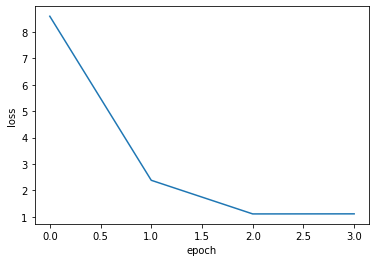

In [49]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [50]:
uv = np.random.random((3,5))
t = uv /np.sqrt(np.sum(np.square(uv), axis=-1, keepdims=True))
np.sum(t*t, axis=-1) 

array([1., 1., 1.])

In [51]:
def cosine_similarity(a,b):
  
  a = a/np.expand_dims(np.linalg.norm(a,axis=-1),axis=-1)
  b = b/np.expand_dims(np.linalg.norm(b,axis=-1),axis=-1)
  dot_prod = np.sum(a*b,axis=-1)
  

  return dot_prod

In [52]:
def predict(a,b, margin=0):
  
  a = tokenizer.texts_to_sequences(a)
  b = tokenizer.texts_to_sequences(b)
  max_length = np.max((len(a),len(b)))
  max_length = 2**int(np.ceil(np.log2(max_length)))

  predict_input1 = tf.keras.preprocessing.sequence.pad_sequences(a,maxlen=max_length,padding=pad,truncating=pad)
  predict_input2 = tf.keras.preprocessing.sequence.pad_sequences(b,maxlen=max_length,padding=pad,truncating=pad)
  vectors = saimese([predict_input1,predict_input2])
  similarity = cosine_similarity(vectors[0], vectors[1])
 # print(similarity.shape)
  if similarity > 0:
    return 1
  else: 
    return 0

In [53]:
predict("How are you?","How you doing?")
predict("What is your age?","How old are you?")
predict("what is your name?","what is your age?")

1

In [72]:

def evaluate(inp, threshold):
  inp = inp.dropna()
  y = inp["is_duplicate"].values
  x1 = inp["question1"].values
  x2 = inp["question2"].values

  x1 = tokenizer.texts_to_sequences(x1)
  x2 = tokenizer.texts_to_sequences(x2) 

  
  total = y.shape[0]
  correct = 0
  true_positive = 0
  true_negative = 0
  false_positive = 0
  false_negative = 0

  per_epoch = 1024
  for i in tqdm.tqdm(range(total//per_epoch)):

    predict_input1 = x1[i*per_epoch:(i+1)*per_epoch]
    predict_input2 = x2[i*per_epoch:(i+1)*per_epoch]
    
    max_len = np.max([np.max([len(x) for x in predict_input1]), np.max([len(x) for x in predict_input2])])

    predict_input1 = tf.keras.preprocessing.sequence.pad_sequences(predict_input1,maxlen=max_length,padding=pad)
    predict_input2 = tf.keras.preprocessing.sequence.pad_sequences(predict_input2,maxlen=max_length,padding=pad)

    y_pred_vectors = saimese([predict_input1,predict_input2])
    y_pred = cosine_similarity(y_pred_vectors[0:per_epoch],y_pred_vectors[per_epoch:])

    y_pred_actual = 1*(y_pred > threshold)
  
    for j in range(per_epoch):
      if y[j]==1 and y_pred_actual[j]==1:
        correct+=1
        true_positive +=1
      elif y[j]==1 and y_pred_actual[j]==0:
        false_negative +=1
      elif y[j]==0 and y_pred_actual[j]==0:
        correct+=1
        true_negative +=1
      elif y[j]==0 and y_pred_actual[j]==1:
        false_positive +=1

  print("\n\nAccuracy: {}".format(correct/ total))

  print("------------------------------------------")
  print("|\t\t\tPredicted Values |")
  print("|\t\t\tTrue \t False\t |")
  print("| Actual\tTrue \t{}\t{}\t |".format(true_positive, false_negative))
  print("| Values\tFalse \t{}\t{}\t |".format(false_positive, true_negative))
  print("------------------------------------------")



  return

In [73]:
full_train_data=pd.read_csv("./data/train.csv")
evaluate(full_train_data, 0.0)

100%|██████████| 394/394 [16:53<00:00,  2.57s/it]



Accuracy: 0.4455745547098967
------------------------------------------
|			Predicted Values |
|			True 	 False	 |
| Actual	True 	113492	41350	 |
| Values	False 	181966	66648	 |
------------------------------------------
